<a href="https://colab.research.google.com/github/Figaero/Canada_Student_Statistics_Tuition_Enrollment/blob/main/STATS_course_GW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Year value is year starting school year.
That is 1992 = 1992/1993

Tuition is in Canadian Dollars
Enrollement/Graduation is number of students

Business case:

A non-profit company is looking to offer scholarship programs for international and canadian students looking to attend post secondary institutions.

They need to understand enrollment levels and how tuition has changed and/or impacted this. They also need to understand graduation levels.

Using available data, explore any changes or unique situations that might impact the company.

- Is tuition change affecting enrollment and graduation
- Note periods of significant change in any factor and explore why/what caused it
- Put a per dollar value on the amount of money lost due to the difference in enrollement and graduation
- Using a 4 year rolling period, assume how many enrolled students graduate on track. Use that average and enrollment per grad each year to compare how much money is spent to get one post sec credential individual out into the labour force.
- Using this number, if you can provide a service and scholarship that helps close this gap or improve these numbers, you can give a dollar value of how much money you might save students

Use this article as a reference point to complete analysis

https://www150.statcan.gc.ca/n1/daily-quotidien/201125/dq201125e-eng.htm

**Conclusion based on Data:**



In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path

In [ ]:
#To mount drive (Only need to use it once)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = r'/content/drive/MyDrive/Statistics Canada Code/Stats Canada'                  # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

df_dict = {}

for file in all_files:
    # Getting the file name without extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    # Reading the file content to create a DataFrame
    df_dict[file_name]= pd.read_csv(file)
    # Setting the file name (without extension) as the index name
    df_dict[file_name].index.name = file_name


<h4>Data Cleaning and Merging

In [ ]:
###################################

tuition_fees = pd.DataFrame(df_dict['Canadian and international tuition fees by level of study'].iloc[:5])
postsec_grad = df_dict['Postsecondary graduates, by field of study, program type, credential type, and gender'].iloc[:2]
postsec_enrol = df_dict['Postsecondary_enrolments_by_field_of_study_registration_status_program_type_credential_type_and_gender'].iloc[:1]
tuitionbtw_92to06 = df_dict['Canadian and international tuition fees by level of study, 1972:1973 to 2006:2007'].iloc[:6]

tuitionbtw_92to06 = tuitionbtw_92to06.rename(columns=tuitionbtw_92to06.iloc[0]).drop(tuitionbtw_92to06.index[0])
tuition_fees = tuition_fees.drop(list(tuition_fees)[:2],axis=1).reset_index()
tuition_fees = tuition_fees.drop(columns = ['Canadian and international tuition fees by level of study'])
tuition_fees = tuition_fees.drop([0]).reset_index()

postsec_grad.drop(list(postsec_grad)[:1],axis=1)
postsec_enrol.drop(list(postsec_enrol)[:1],axis=1)

tuitionbtw_92to06 = tuitionbtw_92to06.drop(list(tuitionbtw_92to06)[:0],axis=1)
tuitionbtw_92to06 = tuitionbtw_92to06.dropna().reset_index()

postsec_grad = postsec_grad.iloc[1:].set_index('Field of study 6')
postsec_enrol = postsec_enrol.set_index('Field of study')


column_name = tuition_fees.columns.values
column_names = list(column_name[2:])

###################################

tuition = pd.concat([tuitionbtw_92to06, tuition_fees[column_names]], axis=1)
tuition = tuition.set_index('Level of study')
tuition = tuition.drop(columns = ['Canadian and international tuition fees by level of study, 1972:1973 to 2006:2007'])

###################################

def split_string(word):
    splited = word.split(" ",1)
    substring = splited[0]
    return substring

enrol = list(postsec_enrol.columns)
money = list(tuition.columns)

new_columns = []
new_money = []
for i in enrol:
    new_columns.append(split_string(i))
    
for i in money:
    new_money.append(split_string(i))

tuition.rename(columns={i:j for i,j in zip(money,new_money)}, inplace=True)

postsec_enrol.rename(columns={i:j for i,j in zip(enrol,new_columns)}, inplace=True)

###################################

postsec = postsec_enrol.append(postsec_grad.iloc[0])
postsec = postsec.reset_index().drop(['Field of study'], axis=1)
new_col = ['Enrollment (Count)','Graduation (Count)']
postsec.insert(loc=0, column='Row ID', value=new_col)

tuition = tuition.reset_index().rename(columns={'Level of study': 'Row ID'})

###################################
#adding new row of tuition year
new_fee = df_dict['Canadian and international tuition fees_2018to2020test']
tuition['2018'] = new_fee['2018']
tuition['2019'] = new_fee['2019']
tuition['2020'] = new_fee['2020']

all_ds = postsec.append(tuition,ignore_index=True)
all_ds['Row ID'] = all_ds['Row ID'].str.replace('graduate', 'graduate($)')

###################################
all_ds = all_ds.replace(',','',regex=True)

tuition = tuition.replace(',','',regex=True)
postsec = postsec.replace(',','',regex=True)

#####################################################
stu_stat = df_dict['Postsecondary_enrolments_by_status_of_studenttest'].reset_index().drop(['Postsecondary_enrolments_by_status_of_studenttest'], axis=1)

#Transposing table
postsec_t = postsec.T
tuition_t = tuition.T

new_header = tuition_t.iloc[0]
tuition_t = tuition_t[1:]
tuition_t.columns = new_header
tuition_t = tuition_t.apply(pd.to_numeric)


tuition_new = tuition_t.copy()
tuition_new['Undergrad_int_per_Cad'] = tuition_new['International undergraduate']/tuition_new['Canadian undergraduate']
tuition_new['Grad_int_per_Cad'] = tuition_new['International graduate']/tuition_new['Canadian graduate']


new = postsec_t.iloc[0]
postsec_t = postsec_t[1:]
postsec_t.columns = new
postsec_t = postsec_t.apply(pd.to_numeric)

postsec_new = postsec_t.copy()
postsec_new['Enrolled_student_per_graduate'] = postsec_new['Enrollment (Count)']/postsec_new['Graduation (Count)']
postsec_desc = postsec_new.describe(include='all')


stu = stu_stat.T
new_head = stu.iloc[0]
stu = stu[1:]
stu.columns = new_head
stu = stu.apply(pd.to_numeric)
sum_column = stu['Canadian students'] + stu['International Students'] + stu['Not reported, status of student in Canada']
stu['Total'] =  sum_column

###################################################
ratio = stu.copy()
ratio = ratio.apply(pd.to_numeric)
ratio['cad_enrol_per_total'] = ratio['Canadian students']/ratio['Total']
ratio['int_enrol_per_total'] = ratio['International Students']/ratio['Total']
ratio['unverified_enrol_per_total'] = ratio['Not reported, status of student in Canada']/ratio['Total']
ratio['Total_ratio'] = ratio['Total']/ratio['Total']

ratio = ratio.drop(columns = ['Canadian students','International Students','Not reported, status of student in Canada','Total'])

In [ ]:
stu
#Use this to guage how many students are enrolled based on status and use ratio to compare graduation and how much is spent in tuition

tuition.to_csv('canada_tuition.csv',encoding='utf-8', index=False)
postsec.to_csv('postsec_stats.csv',encoding='utf-8', index=False)

<h2> Exploratory Data Analysis

Questions to answer:
Tuition
 - Rate of change between each tuition level (Canadian, International, Undergrad, Grad, CanadianVSInternational)
 - Explore why there was a drop (and what year) in tuition for graduate students
 - Explore how the blips in each tuition type affected enrollement during that same time period
 
Enrollement/Graduation
- Rate of change between Enrollement and Graduation, Graduation seems to have steadied while enrollement has been sporadic
- Compare the change in tuition during the same time period as this sporadic change to see if it may have impacted enrollement.

Run one sample t-test to check the increase or decrease in enrollment, graduation and tuition
- Run Student T-test to test hypothesis for enrollement/Graduation data
- Run a one-way ANOVA test on Tuition data
- Run a MANOVA on if tuition impacts enrollement (run using average tuition)

In [ ]:
tuition_desc = tuition_new.describe(include='all')
tuition_desc.round(1)

Row ID,Canadian undergraduate,Canadian graduate,International undergraduate,International graduate,Undergrad_int_per_Cad,Grad_int_per_Cad
count,29.0,29.0,29.0,29.0,29.0,29.0
mean,4446.2,5003.6,15139.1,11695.7,3.3,2.4
std,1536.5,1711.9,7373.4,3557.3,0.5,0.4
min,1872.0,1932.0,6221.0,6397.0,2.7,2.0
25%,3328.0,3601.0,9061.0,8640.0,2.9,2.2
50%,4347.0,5448.0,13205.0,12337.0,3.3,2.3
75%,5767.0,6295.0,19416.0,13490.0,3.4,2.5
max,6822.0,7388.0,32019.0,19252.0,4.9,3.4


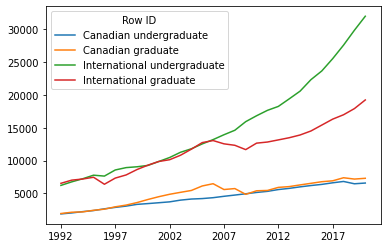

In [ ]:
tuition_t.plot.line()

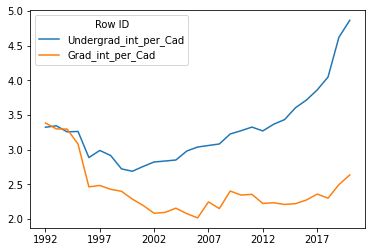

In [ ]:
#Visualization of ratio for international student tuition and Canadian tuition
tuition_new[['Undergrad_int_per_Cad','Grad_int_per_Cad']].plot.line()

Elaborate on this

29 years worth of data of average tuition across canada for each education level

- Average international undergraduate level student paid 3.3 times what a Canadian would pay while the graduate level equivalent was 2.4. This has gone up consisitenly since 2012 and is currently at its highest point ever (4.9 times the canadian equivalent)

- The Standard deviation shows that the international undergraduate fees have a much wider difference between values

- The difference between quantiles in the canadian tuition levels and international graduate level is consistent while the International undergraduate level values are sporadic

- Graduate tuition category is the only group to experience a drop in cost of tuition.

- Disparity between undergradute and graduate tuition for international students has grown immensly, especially when compared to the rate of increase between the Canadian equivalent. Could there be a reason?

- International Undergraduate tuition has risen at a much higher rate compared to the other types.

- When compared to the canadian equivalent, International undergrad tuition cost has risen at a higher rate consistently since 2000 while international graduate tuition has stayed within the same rate of increase to its canadian equivalent. Both experienced a sharp decline in the late 90s

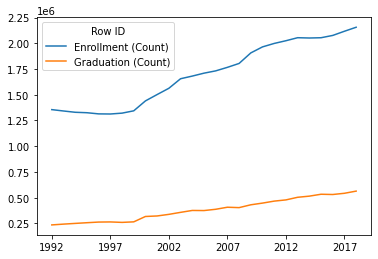

In [ ]:
#Visualization of count of enrollment and graduated student per year
postsec_t.plot.line()

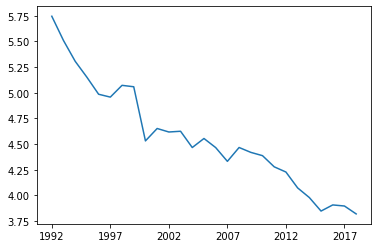

In [ ]:
#Visualization of ratio of enrolled students per graduated student in the same year
postsec_new['Enrolled_student_per_graduate'].plot.line()

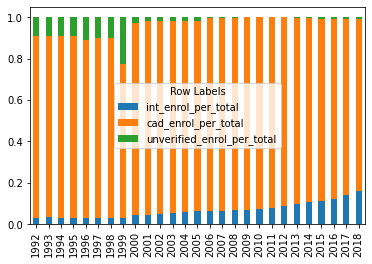

In [ ]:
#Visualization of ratio for enrollment data in relation to student status compared to total number of enrolled students
ratio[['int_enrol_per_total','cad_enrol_per_total','unverified_enrol_per_total']].plot.bar(stacked=True)

Expand on this:

- More students are graduating from schools when compared to the number of students being enrolled in the same year.
- The percentage of International students as part of the total number of students enrolled in post seconschools has doubled since 2008, currently sitting at 16%.

In [ ]:
#Calculate percentage change in columns

diff = tuition.set_index(['Row ID'])
diff = diff.astype('int')
different = diff.pct_change(axis=1)
different = different.T

post = postsec.set_index(['Row ID'])
post = post.astype('int')
posted = post.pct_change(axis=1)
posted = posted.T

status = stu_stat.set_index(['Row Labels'])
status = status.astype('int')
status = status.pct_change(axis=1).T

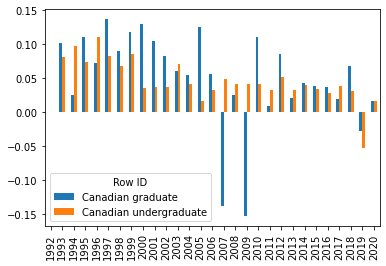

In [ ]:
#Percentage rate of change for Canadian status student tuition data
different[['Canadian graduate','Canadian undergraduate']].plot.bar()

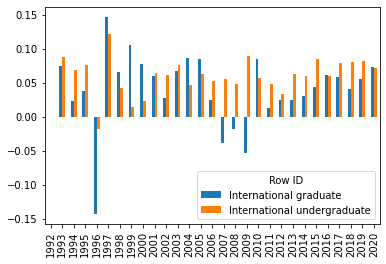

In [ ]:
#Percentage rate of change for international status student tuition data
different[['International graduate','International undergraduate']].plot.bar()

In [ ]:
#Descriptive statistics for tuition data percentage change
done = different.describe(include='all')
done.round(2)

Row ID,Canadian undergraduate,Canadian graduate,International undergraduate,International graduate
count,28.00,28.00,28.00,28.00
mean,0.05,0.05,0.06,0.04
std,0.03,0.07,0.03,0.06
min,-0.05,-0.15,-0.02,-0.14
25%,0.03,0.02,0.05,0.02
50%,0.04,0.06,0.06,0.05
75%,0.07,0.10,0.08,0.07
max,0.11,0.14,0.12,0.15


Ignoring potential outliers, tuition for international students seems to have increased at the only marginally higher percentage compared to canadian tuition. This marginal change has been larger enough to be affect the cost of tuition 

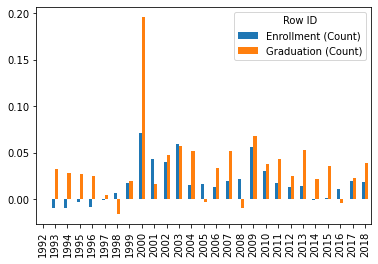

In [ ]:
#Percentage rate of change for enrollement and graduation together.
posted[['Enrollment (Count)','Graduation (Count)']].plot.bar()

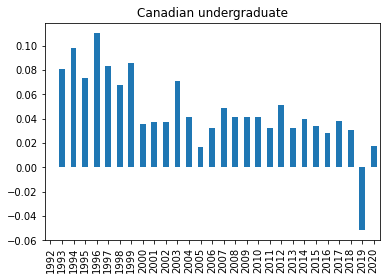

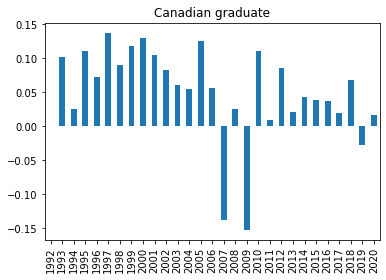

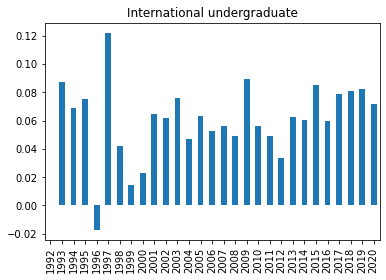

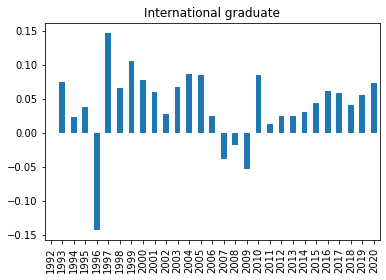

In [ ]:
#Percentage rate of change for tuition per year
for i, col in enumerate(different.columns):
    different[col].plot.bar(fig=plt.figure(i))
    plt.title(col)

plt.show()

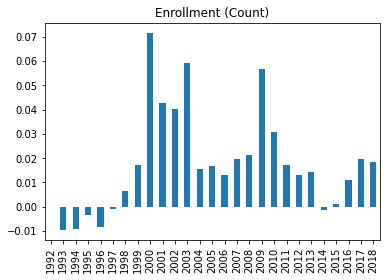

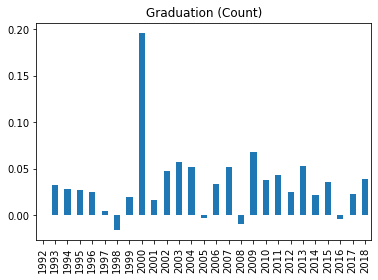

In [ ]:
#Percentage change for rate of enrollment and graduation per year
for i, col in enumerate(posted.columns):
    posted[col].plot.bar(fig=plt.figure(i))
    plt.title(col)

plt.show()

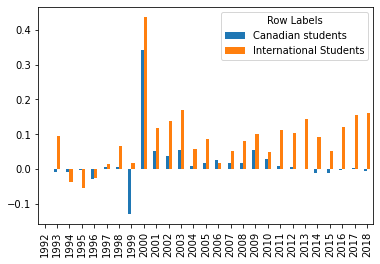

In [ ]:
status[['Canadian students','International Students']].plot.bar()

In [ ]:
status.describe(include='all').round(2)

Row Labels,Canadian students,International Students,"Not reported, status of student in Canada"
count,26.00,26.00,26.00
mean,0.02,0.09,0.15
std,0.07,0.09,0.74
min,-0.13,-0.05,-0.86
25%,-0.00,0.05,-0.19
50%,0.01,0.09,-0.03
75%,0.02,0.12,0.17
max,0.34,0.44,2.37


In [ ]:
test = posted.describe(include='all')
test.round(2)

Row ID,Enrollment (Count),Graduation (Count)
count,26.00,26.00
mean,0.02,0.03
std,0.02,0.04
min,-0.01,-0.02
25%,0.00,0.02
50%,0.02,0.03
75%,0.02,0.05
max,0.07,0.20
